In [1]:
import pandas as pd, numpy as np
import os
import matplotlib.pyplot as plt
from datetime import timedelta,date
from dateutil.parser import parse
from ResearchML import *
from mlfinlab.microstructural_features import *
from mlfinlab.sample_weights import *

workPath = "/home/xetra/AlphaGoldmine/Data/"
future = "CL"

contFuture = os.path.join(workPath, future.lower(), f"{future}Cont")
betasPath = os.path.join(workPath, future.lower(), f"{future}TermStructure")

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [2]:
monthMap = {
    "F": 1,
    "G": 2,
    "H": 3,
    "J": 4,
    "K": 5,
    "M": 6,
    "N": 7,
    "Q": 8,
    "U": 9,
    "V": 10,
    "X": 11,
    "Z": 12,
}

cols = {
#     'Date' : "date",
#     ' Time' : "time",
    ' Open' : "o",
    ' High' : "h",
    ' Low' : "l",
    ' Last' : "c",
    ' Volume' : "vol",
    ' # of Trades' : "nrT",
    ' Bid Volume' : "bidVol",
    ' Ask Volume' : "askVol",
    'Date_ Time' : "date",
    "contract": "contract"
}

In [3]:
fileNames = []
for i in range(10, 21, 1):
    for m in monthMap:
        try: fileNames.append(os.path.join(workPath, future.lower(), f"{future}{m}{i}.csv"))
        except(FileNotFoundError): continue

In [4]:
def getDf(p):
    s = f"{future}{p[len(p)-7:-4]}"
    df = pd.read_csv(p, parse_dates=[["Date", " Time"]]).rename(columns={"Date_ Time":"date"})
    return df.drop_duplicates(subset=["date"], keep="last").set_index("date")[" Last"].rename(s)

with mp.Pool(processes=mp.cpu_count()-1) as p:
    res = p.map(getDf, fileNames)
    df = pd.concat(res,1)

In [5]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [6]:
df=df.sort_index().reset_index()
dt = df["date"]
df = df.drop("date",1)

In [7]:
df.columns

Index(['CLF10', 'CLG10', 'CLH10', 'CLJ10', 'CLK10', 'CLM10', 'CLN10', 'CLQ10',
       'CLU10', 'CLV10',
       ...
       'CLH20', 'CLJ20', 'CLK20', 'CLM20', 'CLN20', 'CLQ20', 'CLU20', 'CLV20',
       'CLX20', 'CLZ20'],
      dtype='object', length=132)

In [8]:
df["date"] = dt

In [9]:
df=df.set_index("date")

In [10]:
for c in list(df):
    df.loc[df[c].first_valid_index():df[c].last_valid_index(),c].fillna(method="ffill", inplace=True)

In [11]:
cAsDate={k:v for k,v in [f for f in zip([f for f in df.columns],[date(2000+int(c[3:]),monthMap[c[2]],20) for c in df.columns])]}

# Modeling The Term Structure with Static Nelson-Siegel model

**Note**: I modified the [code] below to my needs based on [Barunik & Malinska 2015]

The authors derived optimal $\lambda^*$ of $\lambda^*=0.0058$ and suggested to use static(optimal) lambda rather dynamic one $\lambda_t$. The benefit are much less computation and better prediction due to stable(static) $\lambda$. But I will not predict term structure here, rather derive minimal betas to describe the term structure curve.

$exp=e^{-\lambda^*\tau_t}$

$factor1=\frac{1-exp}{\lambda^*\tau_t}$

$\underset{\beta_0,\beta_1,\beta_2}{min} \sum_{i=1}^N(p_t(\tau_i)-\beta_0-\beta_1(factor1)-\beta_2(factor1-exp))^2$

where $p_t(\tau_i)$ is WTI futures price at time $t$ with time to maturity in days $\tau_i$.

[code]: https://github.com/luphord/nelson_siegel_svensson/tree/master/nelson_siegel_svensson
[Barunik & Malinska 2015]: https://www.researchgate.net/publication/275279733_Forecasting_the_term_structure_of_crude_oil_futures_prices_with_neural_networks

In [12]:
from numbers import Real
from dataclasses import dataclass
from typing import Union, Tuple

import numpy as np
from numpy import exp

EPS = np.finfo(float).eps


@dataclass
class NelsonSiegelCurve:
    '''Implementation of a Nelson-Siegel interest rate curve model.
       This curve can be interpreted as a factor model with three
       factors (including a constant).
    '''

    beta0: float
    beta1: float
    beta2: float
    L: float

    def factors(self, T: Union[Real, np.ndarray]) -> Union[Tuple[Real, Real], Tuple[np.ndarray, np.ndarray]]:
        '''Factor loadings for time(s) T, excluding constant.'''
        L = self.L
        if isinstance(T, Real) and T <= 0:
            return 1, 0
        elif isinstance(T, np.ndarray):
            zero_idx = T <= 0
            T[zero_idx] = EPS  # avoid warnings in calculations
        exp_tt0 = exp(-L*T)
        factor1 = (1 - exp_tt0)/(L*T)
        factor2 = factor1 - exp_tt0
        if isinstance(T, np.ndarray):
            T[zero_idx] = 0
            factor1[zero_idx] = 1
            factor2[zero_idx] = 0
        return factor1, factor2

    def factor_matrix(self, T: Union[Real, np.ndarray]) -> Union[Real, np.ndarray]:
        '''Factor loadings for time(s) T as matrix columns, including constant column (=1.0).'''
        factor1, factor2 = self.factors(T)
        constant = np.ones(T.size) if isinstance(T, np.ndarray) else 1
        return np.stack([constant, factor1, factor2]).transpose()

    def zero(self, T: Union[Real, np.ndarray]) -> Union[Real, np.ndarray]:
        '''Zero rate(s) of this curve at time(s) T.'''
        factor1, factor2 = self.factors(T)
        return self.beta0 + self.beta1*factor1 + self.beta2*factor2

    def __call__(self, T: Union[Real, np.ndarray]) -> Union[Real, np.ndarray]:
        '''Zero rate(s) of this curve at time(s) T.'''
        return self.zero(T)

In [13]:
from typing import Tuple, Any
from numpy.linalg import lstsq
from scipy.optimize import minimize

def _assert_same_shape(t: np.ndarray, y: np.ndarray) -> None:
    assert t.shape == y.shape, 'Mismatching shapes of time and values'

def betas_ns_ols(betas: Tuple ,L: float, t: np.ndarray, y: np.ndarray) -> Tuple[NelsonSiegelCurve, Any]:
    '''Calculate the best-fitting beta-values given tau
       for time-value pairs t and y and return a corresponding
       Nelson-Siegel curve instance.
    '''
    _assert_same_shape(t, y)
    curve = NelsonSiegelCurve(*betas, L)
    factors = curve.factor_matrix(t)
    lstsq_res = lstsq(factors, y, rcond=None)
    beta = lstsq_res[0]
    return NelsonSiegelCurve(beta[0], beta[1], beta[2], L), lstsq_res

def errorfn_ns_ols(betas:Tuple, L: float, t: np.ndarray, y: np.ndarray) -> float:
    '''Sum of squares error function for a Nelson-Siegel model and
       time-value pairs t and y. All betas are obtained by ordinary
       least squares given tau.
    '''
    _assert_same_shape(t, y)
    curve, lstsq_res = betas_ns_ols(betas,L, t, y)
    return np.sum((y-curve(t))**2)


def calibrate_ns_ols(t: np.ndarray, y: np.ndarray, L=0.0058) -> Tuple[NelsonSiegelCurve, Any]:
    '''Calibrate a Nelson-Siegel curve to time-value pairs 
       t and y, by optimizing tau and chosing all betas
       using ordinary least squares.
    '''
    _assert_same_shape(t, y)
    opt_res = minimize(errorfn_ns_ols, x0=[0,0,0], args=(L, t, y))
    betas=(opt_res.x[0],opt_res.x[1],opt_res.x[2])
    curve, lstsq_res = betas_ns_ols(betas, L, t, y)
    return curve, opt_res

In [76]:
def minBetas(row,L=0.0058):
    tau=np.array([abs(cAsDate[i]-row.name.date())/timedelta(days=1) for i in row.index])
    curve,_=calibrate_ns_ols(tau,row,L)
    return pd.Series([curve.beta0,curve.beta1,curve.beta2],index=["b0","b1","b2"],name=row.name)

In [66]:
split = np.array_split(df,16)

In [89]:
def simpleMPBetas(df):
    res=[]
    for _,row in df.iterrows():
        res.append(minBetas(row.dropna()))
    return pd.concat(res,axis=1).T

In [90]:
import multiprocessing as mp
with mp.Pool(16) as p:
    res = p.map(simpleMPBetas,split)

In [91]:
betas = pd.concat(res)

<AxesSubplot:title={'center':'Term Structure Betas'}>

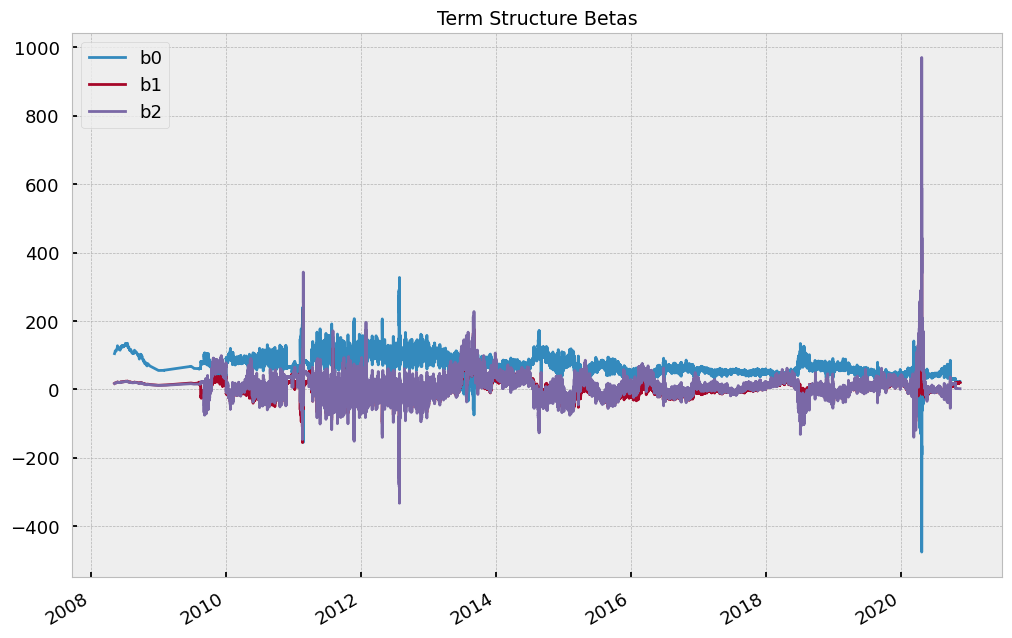

In [98]:
betas.plot(title="Term Structure Betas")

In [99]:
betas.reset_index().to_feather(betasPath)

In [21]:
# # Pandas.apply variant, was constantly running out of ram(64GB) before
# def applyMinBetas(r,L=0.0058):
#     row=r.dropna()
#     tau=np.array([abs(cAsDate[i]-row.name.date())/timedelta(days=1) for i in row.index])
#     curve,_=calibrate_ns_ols(tau,row,L)
#     return pd.Series([curve.beta0,curve.beta1,curve.beta2],index=["b0","b1","b2"],name=row.name)

# tmp=[]
# for d in tqdm(split):
#     tmp.append(d.apply(applyMinBetas))